<a href="https://colab.research.google.com/github/julianderks/Notebooks/blob/main/Anomaly_Detection_Isolation_forest_Multivariate_Synthetic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pre-amble

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

In [2]:
# Set custom default plot theme
from matplotlib import cycler
colors = cycler('color',['#EE6666', '#3388BB', '#9988DD','#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2, markersize=1.5)

### Helper functions

In [3]:
# Draw samples from multivariate normal distribution
def draw_anomaly_sample(mean = np.array([0, 0]), cov = np.array([[1,.5],[.5,1]]), size = 1000, smallsample_ratio=40):
  sample = np.random.multivariate_normal(mean,cov, size)
  anomaly_sample_1 =  np.random.multivariate_normal([0,-5], cov, size//smallsample_ratio)
  anomaly_sample_2 =  np.random.multivariate_normal([0, 5], cov, size//smallsample_ratio)

  return np.concatenate((sample, anomaly_sample_1, anomaly_sample_2))

In [4]:
def visualize_sample(X, ax=None):
  if ax is None:
    ax = plt.gca()

  a = ax.scatter(X[:,0], X[:,1], s = 20, edgecolors='k', linewidths=.5)
  ax.set_title(f'Multivariate-Normal Sample with Anomalies')
  ax.set_xlabel('Random Variable 1')
  ax.set_ylabel('Random Variable 2')
  ax.legend([a],['Sampled point'], facecolor='white')
  return

def visualize_anomalies(outliers, inliers, treshold, resolution = 100, ax=None, legend=True, title=None):
  if ax is None:
      ax = plt.gca()

  xx , yy = np.meshgrid(np.linspace(0, 1, resolution), np.linspace(0, 1, resolution))
  Z = clfIF.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
  Z = Z.reshape(xx.shape)

  # Decision boundary
  c = ax.contour(xx, yy, Z, levels=[treshold], linewidths=3, colors='red', linestyles='dotted')

  # Inlier Region
  inlierRegionColor = 'orange'
  ax.contourf(xx, yy, Z, levels=[treshold, Z.max()], colors=inlierRegionColor)
  inlierRegion = matplotlib.patches.Patch(facecolor='orange', edgecolor='r', label=inlierRegionColor)

  # 4 Color uniform levels between the min and max anomaly scores
  k = ax.contourf(xx, yy, Z, cmap=plt.cm.Blues_r, levels=np.linspace(Z.min(), treshold, 5))
  cbar = plt.colorbar(k, ax=ax)
  cbar.ax.set_ylabel('Outlier level', rotation=270, labelpad=15)
  cbar.ax.set_yticklabels(["{:.2f}".format(i) for i in cbar.get_ticks()])

  # Inliers points
  a = ax.scatter(inliers[:,0], inliers[:,1], s = 20, edgecolors='k', color='white', linewidths=.5)
  # Outliers points
  b = ax.scatter(outliers[:,0], outliers[:,1], s = 20, edgecolors='k', color='black', linewidths=.5)
  if legend:
    ax.legend([a, b, c.collections[0], inlierRegion], ['Inliers','Outliers', 'Learned decision function', 'Inlier region'])    
  if title is None:
    ax.set_title('Isolation Forest (IF)')
  else:
    ax.set_title(title)

  ax.set_xlabel('Random Variable 1')
  ax.set_ylabel('Random Variable 2')
  return

In [5]:
def generate_forest(X, n_estimators):
  # Scale both dimensions between [0,1]
  minmax = MinMaxScaler()
  X = minmax.fit_transform(data)

  # Define & Fit the classifier
  clfIF = IsolationForest(n_estimators=n_estimators, n_jobs=-1)
  clfIF.fit(X)

  return clfIF, X

def make_predictions(clfIF, X, treshold):
  scores_pred = clfIF.decision_function(X) 
  pred = np.where(scores_pred < treshold, -1, 1)
  outliers = X[pred == -1]
  inliers = X[pred == 1]

  return scores_pred, pred, outliers, inliers

### Isolation Forest

In [6]:
data = draw_anomaly_sample(smallsample_ratio=10)
clfIF, X = generate_forest(data, n_estimators=1000)

# By default IF applies rule: score < 0 = anomaly. We can play with this threshold to play with the 
# trade-off: More TP & FP / More TN & FN
# FN = False Negative (Label Anomaly as Normal) # TN = True Negative (Label Normal as Normal)
# FP = False Positive (Label Normal as Anomaly) # TN = True Positive (Label Anomaly as Anomaly)
customThreshold = 0

scores_pred, pred, outliers, inliers = make_predictions(clfIF, X, customThreshold)

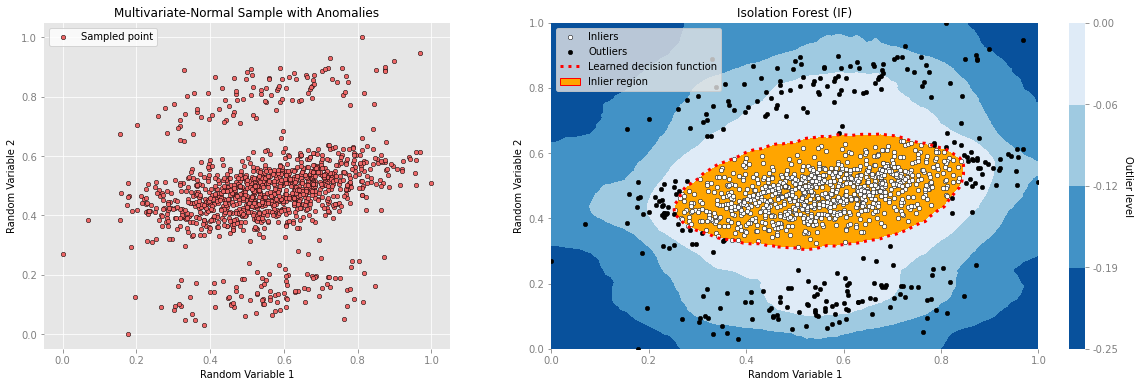

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), gridspec_kw={'width_ratios': [2, 3]})
visualize_sample(X, ax=ax1)
visualize_anomalies(outliers, inliers, customThreshold, resolution = 100, ax=ax2)

### **Experiment 1:** *Increasing the size of the anomaly samples*

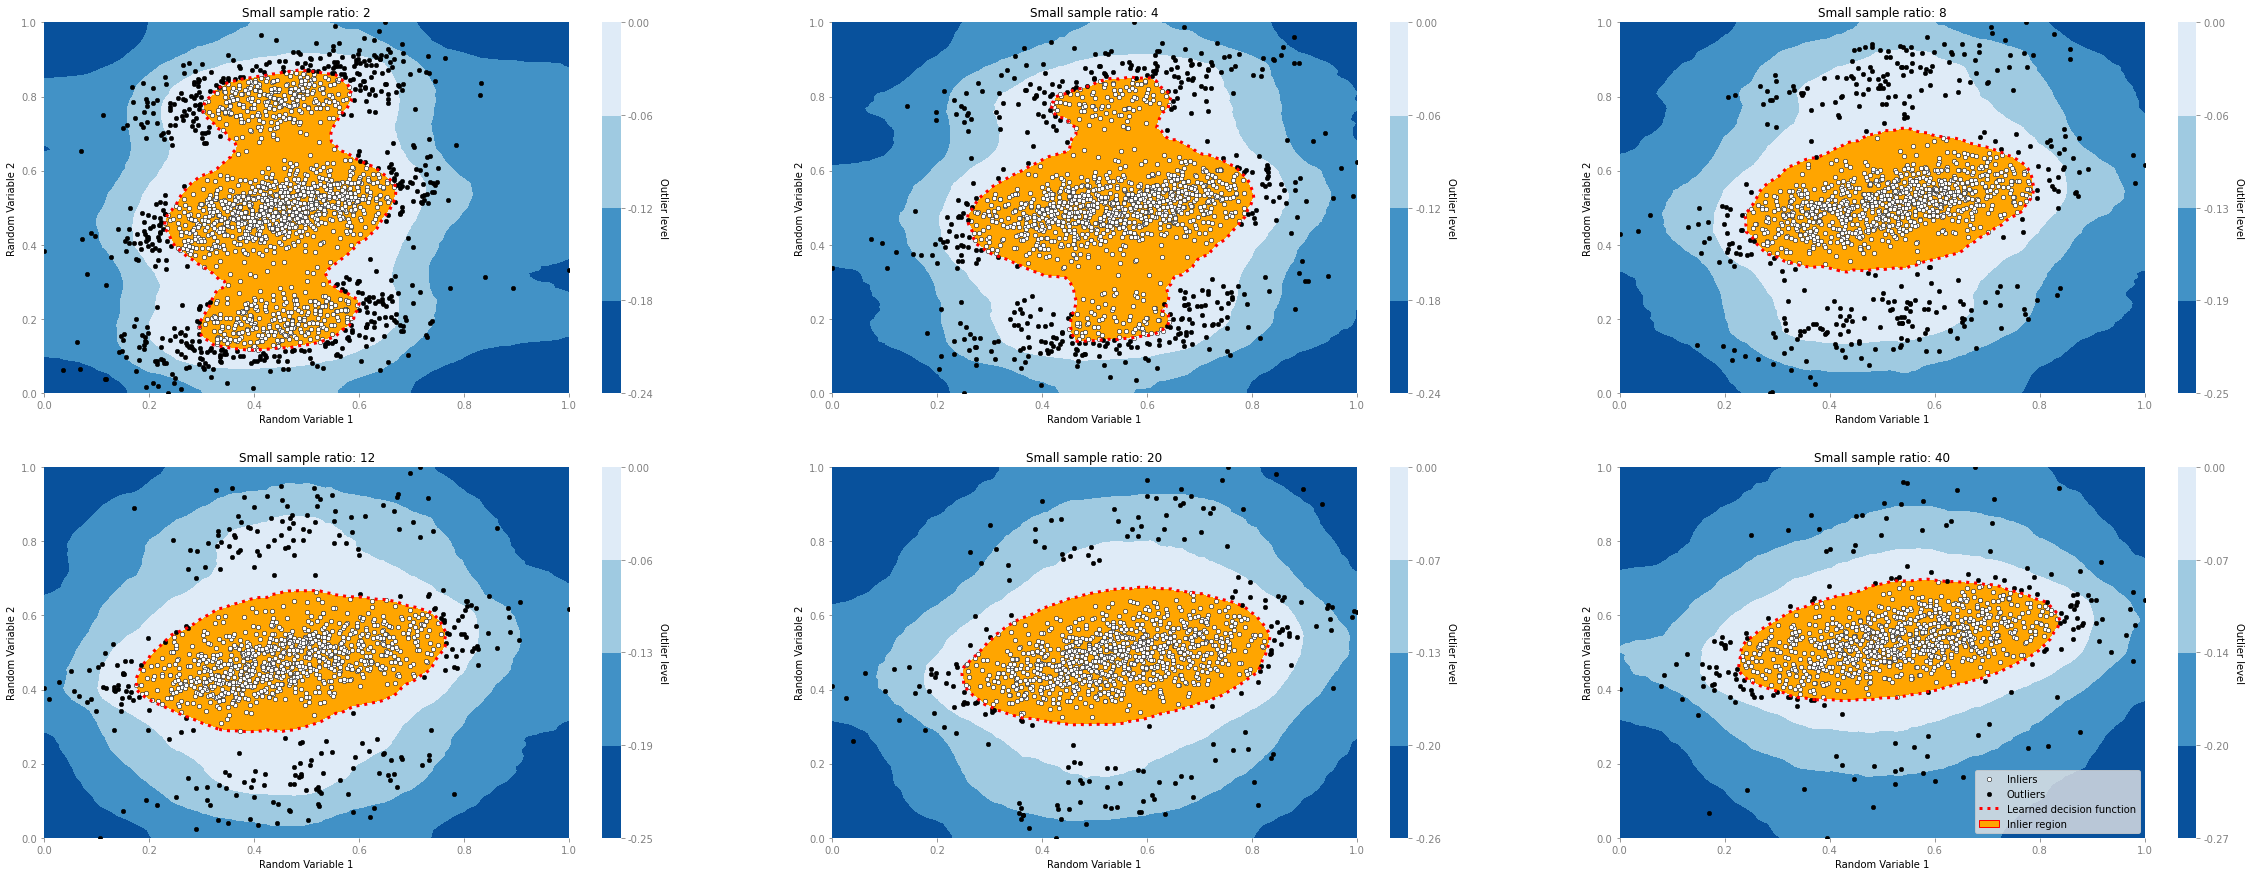

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(40,15))

for ax, ratio in zip(axs.flatten(), [2,4,8,12,20,40]):
  data = draw_anomaly_sample(smallsample_ratio=ratio)
  clfIF, X = generate_forest(data, n_estimators=1000)
  _, _, outliers, inliers = make_predictions(clfIF, X, customThreshold)

  visualize_anomalies(outliers, inliers, customThreshold, ax=ax, 
                      legend = True if ratio == 40 else False,
                      title = f'Small sample ratio: {ratio}')

### **Experiment 2:** *Increasing the treshold of anomaly predictions*

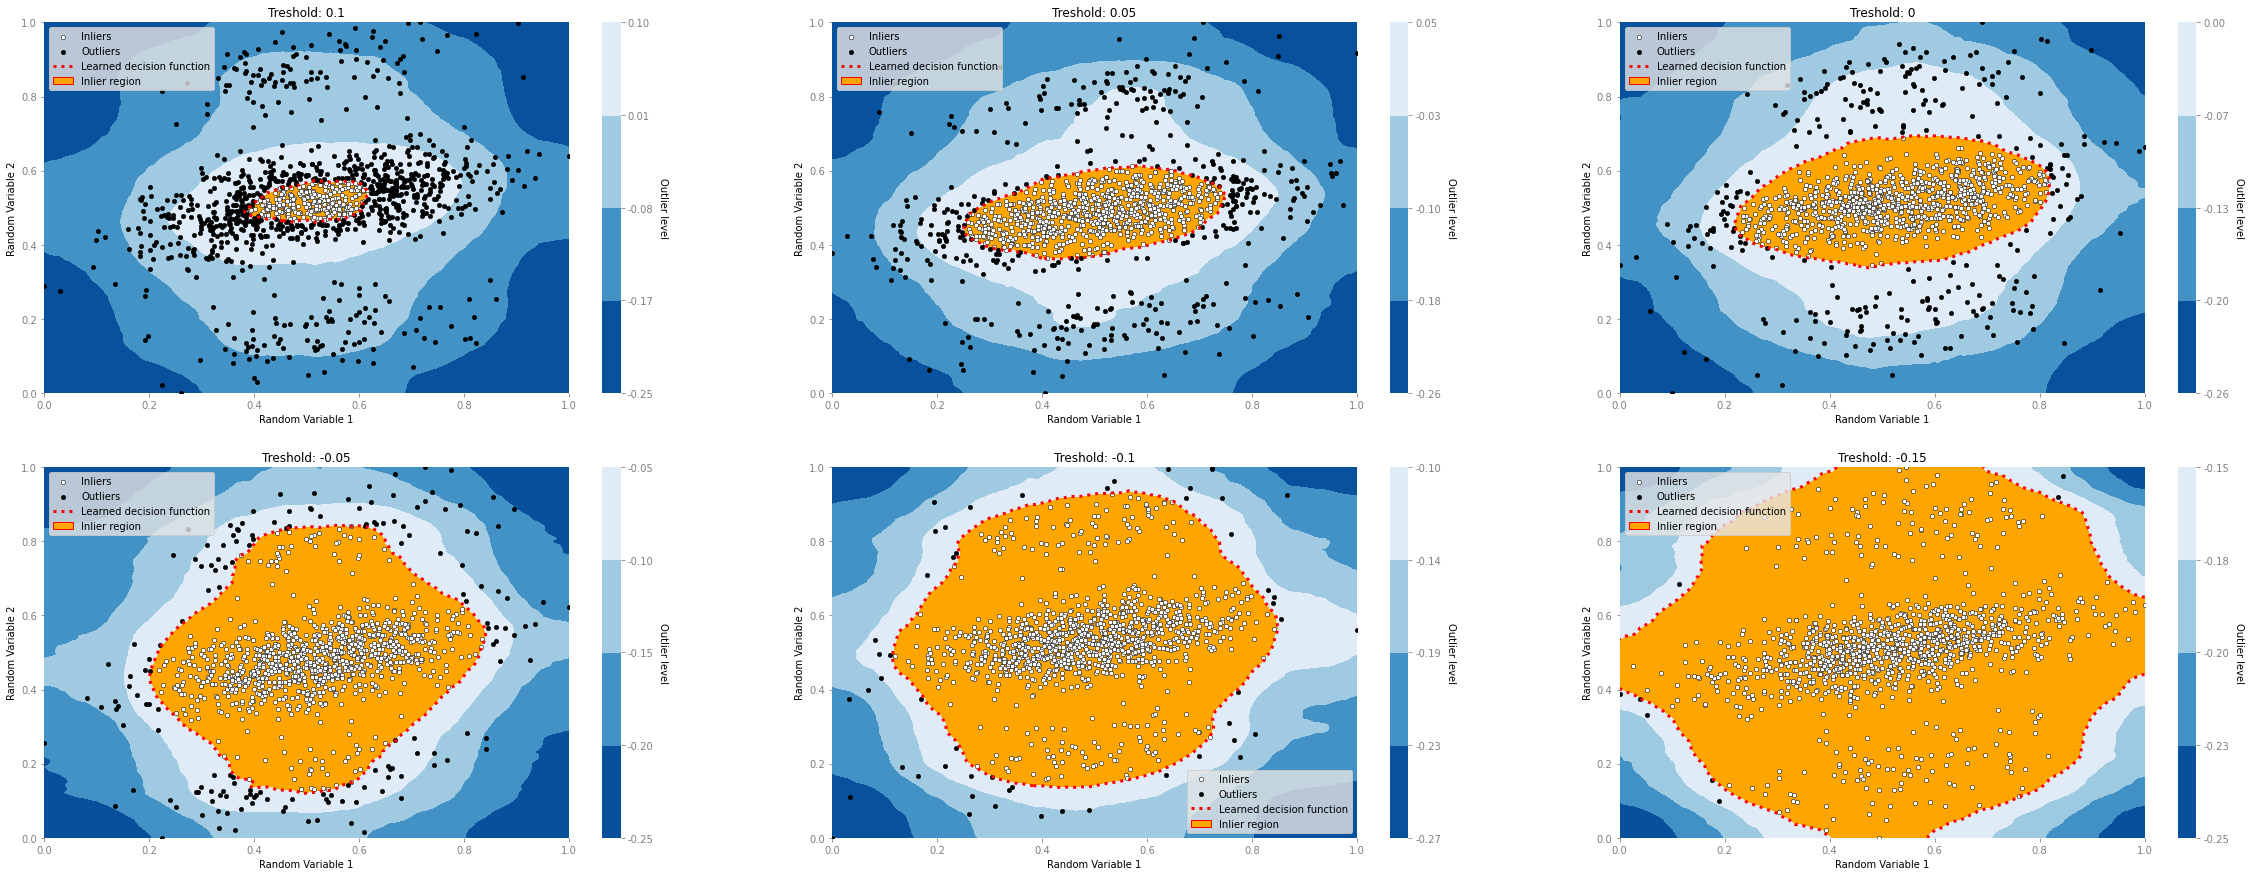

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(40,15))

for ax, treshold in zip(axs.flatten(), [.10 ,.05, 0,-.05,-.10,-.15]):
  data = draw_anomaly_sample(smallsample_ratio=10)
  clfIF, X = generate_forest(data, n_estimators=1000)
  _, _, outliers, inliers = make_predictions(clfIF, X, treshold)

  visualize_anomalies(outliers, inliers, treshold, ax=ax, 
                      legend = True if ratio == 40 else False,
                      title = f'Treshold: {treshold}')